In [ ]:
import numpy as np
np.random.seed(42) # results are reproducible and comparable across different runs

In [ ]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
CMD = ConfusionMatrixDisplay
from sklearn.metrics import classification_report
CR = classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [ ]:
import gensim

In [ ]:
import spacy
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/fake_papers_train_part_public.csv')
df = df.drop(columns = ['id'], axis = 1)
print(df.shape)
df.head()

(5350, 2)


,text,fake
0,Modern two-dimensional imaging is of such qual...,0
1,Background: The optimal sequence of systemic p...,1
2,This chapter opens with a discussion of the ef...,1
3,The time scale of the ultra-short-term can str...,1
4,Electronic nose or machine olfaction are syste...,1


In [ ]:
count_0s = df['fake'].value_counts()[0]
count_1s = df['fake'].value_counts()[1]

print("Number of 0s:", count_0s)
print("Number of 1s:", count_1s)


Number of 0s: 1686
Number of 1s: 3664


We are resampling to balance counts of 0s and 1s , and therefore ensure a uniform distribution of both 0s and 1s.

###Preprocessing and importing libraries

1 stands for the generated content and 0 stands for human-written content.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = ''.join(c for c in text if c.isalpha() or c.isspace())
    doc = nlp(text)
    text = [token.lemma_ for token in doc]
    return ' '.join(text)

# Apply the clean_text function to each row of the 'text' column in the dataframe
df['cleanedtext'] = df['text'].apply(lambda x: clean_text(x.lower()))

# Create a new column to store the lists of cleaned text for each document
df['cleanedtext_list'] = None

# Loop through each row in the dataframe and store the cleaned text for each document in a list
for index, row in df.iterrows():
    cleaned_text_list = row['cleanedtext'].split()
    df.at[index, 'cleanedtext_list'] = cleaned_text_list
df = df.drop('cleanedtext', axis=1)

# Print the first 5 rows of the dataframe to check the new column
df.head(5)

,text,fake,cleanedtext_list
0,Modern two-dimensional imaging is of such qual...,0,"[modern, twodimensional, imaging, be, of, such..."
1,Background: The optimal sequence of systemic p...,1,"[background, the, optimal, sequence, of, syste..."
2,This chapter opens with a discussion of the ef...,1,"[this, chapter, open, with, a, discussion, of,..."
3,The time scale of the ultra-short-term can str...,1,"[the, time, scale, of, the, ultrashortterm, ca..."
4,Electronic nose or machine olfaction are syste...,1,"[electronic, nose, or, machine, olfaction, be,..."


In [ ]:
df['fake'].value_counts()

1    3664
0    1686
Name: fake, dtype: int64

In [ ]:
X = list(df['cleanedtext_list'])
y = list(df['fake'])

In [ ]:
# Split the data into training and test sets for normal df
X_val_train, X_test, y_val_train, y_test = train_test_split(df['cleanedtext_list'], df['fake'], test_size=0.2,random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

##Word2vec Continuous Bag Of Words

In [ ]:
# Train a C bow Word2Vec model on the training data
w2v_model = gensim.models.Word2Vec(X_val_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2,
                                   workers=4,
                                   sg=0)  # set sg=0 to use Continuous Bag of Words

In [ ]:
words = set(w2v_model.wv.index_to_key)

In [ ]:
# Vectorize the training and test data using the trained Skip Gram Word2Vec model
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                        for ls in X_test])

<ipython-input-41-89338a9c01c2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-41-89338a9c01c2>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [ ]:
# Average the word vectors for each sentence (and assign a vector of zeros if the model
# did not learn any of the words in the text message during training)
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Mean accuracy on validation set:  0.6871495327102803
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 4}
Mean accuracy on validation set:  0.6871495327102803
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
Mean accuracy on validation set:  0.6871495327102803
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 2}
Mean accuracy on validation set:  0.6871495327102803
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4}
Mean accuracy on validation set:  0.6871495327102803
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 10}
Mean accuracy on validation set:  0.6871495327102803
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2}
Mean accuracy on validation set:  0.

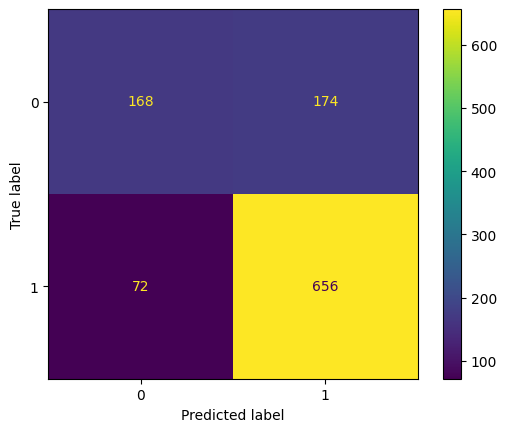

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#pipeline for feature extraction using Tfidf and random forest model
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

#hyperparameters to tune
params = {
    'clf__max_depth': [2, 4, 6],
    'clf__min_samples_split': [2, 4, 10],
    'clf__min_samples_leaf': [4, 6, 8]
}
# Use GridSearchCV to tune hyperparameters and select the best model
grid_search = GridSearchCV(pipeline, params, cv=4)
grid_search.fit(X_train_vect_avg, y_val_train.values.ravel())

#results of the grid search
results = grid_search.cv_results_

# Print the performance for each set of hyperparameters
for i in range(len(results['params'])):
    print("Parameters: ", results['params'][i])
    print("Mean accuracy on validation set: ", results['mean_test_score'][i])

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test_vect_avg)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression

#pipeline for feature extraction using Tfidf and logistic regression model
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,random_state=42))
])

#hyperparameters to tune
params = {
    'clf__C': [ 0.01, 0.1, 1, 5, 8, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
}

# Use GridSearchCV to tune hyperparameters and select the best model
grid_search = GridSearchCV(pipeline, params, cv=4,error_score=0)
grid_search.fit(X_train_vect_avg, y_val_train.values.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=4, error_score=0,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 5, 8, 10],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear', 'saga']})

In [ ]:
# Get the results of the grid search
results = grid_search.cv_results_

# Print the performance metrics for each set of hyperparameters on validation set
for i in range(len(results['params'])):
    print("Parameters: ", results['params'][i])
    print("Mean accuracy on validation set: ", results['mean_test_score'][i])

Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.685981308411215
Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Mean accuracy on validation set:  0.685981308411215
Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.702570093457944
Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Mean accuracy on validation set:  0.7037383177570093
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.7042056074766355
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Mean accuracy on validation set:  0.7046728971962617
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.7212616822429907
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Mean accuracy on

Best Parameters: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Test Accuracy: 0.7607
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       342
           1       0.80      0.87      0.83       728

    accuracy                           0.76      1070
   macro avg       0.73      0.70      0.71      1070
weighted avg       0.75      0.76      0.75      1070



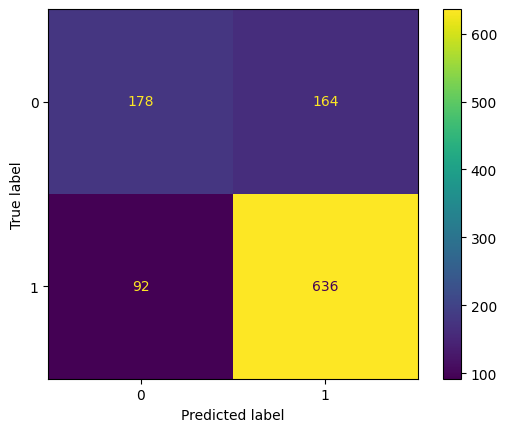

In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test_vect_avg)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mean cross-validation score: 0.8084
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.7963
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       342
           1       0.84      0.87      0.85       728

    accuracy                           0.80      1070
   macro avg       0.77      0.76      0.76      1070
weighted avg       0.79      0.80      0.79      1070



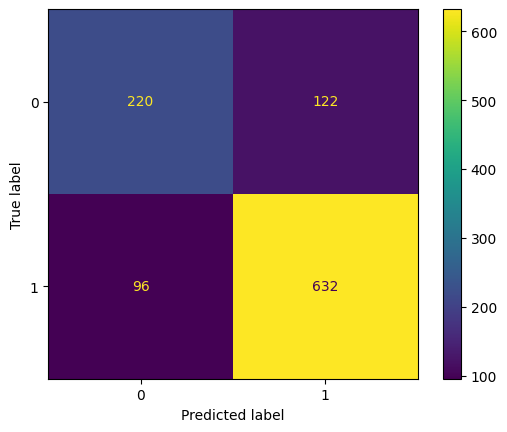

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the SVM model
svc = SVC()

# Define the hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_vect_avg, y_val_train.values.ravel())

# Print the best hyperparameters and the corresponding mean cross-validation score
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Mean cross-validation score: {grid_search.best_score_:.4f}')

# Use the best model to make predictions on the test data
y_pred = grid_search.predict(X_test_vect_avg)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test_vect_avg)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.7925
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       342
           1       0.84      0.87      0.85       728

    accuracy                           0.79      1070
   macro avg       0.76      0.75      0.76      1070
weighted avg       0.79      0.79      0.79      1070



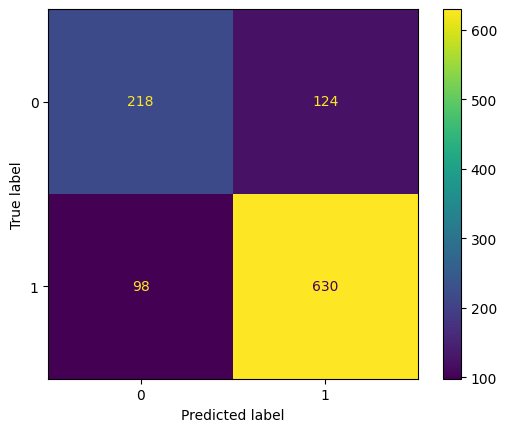

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp_model = mlp.fit(X_train_vect_avg, y_val_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = mlp_model.predict(X_test_vect_avg)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

Test Accuracy: 0.7804
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       342
           1       0.82      0.87      0.84       728

    accuracy                           0.78      1070
   macro avg       0.75      0.73      0.74      1070
weighted avg       0.78      0.78      0.78      1070



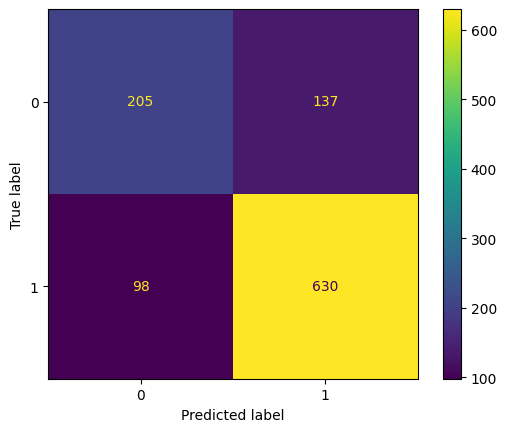

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb_model = gb.fit(X_train_vect_avg, y_val_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = gb_model.predict(X_test_vect_avg)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

## Word2Vec(Skip Gram)

In [ ]:
import gensim
import numpy as np
import pandas as pd

In [ ]:
# Train a Skip Gram Word2Vec model on the training data
w2v_model = gensim.models.Word2Vec(X_val_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2,
                                   workers=4,
                                   sg=1)  # set sg=1 to use the Skip Gram algorithm

In [ ]:
words = set(w2v_model.wv.index_to_key)

In [ ]:
# Vectorize the training and test data using the trained Skip Gram Word2Vec model
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                        for ls in X_test])

<ipython-input-56-89338a9c01c2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-56-89338a9c01c2>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [ ]:
# Average the word vectors for each sentence (and assign a vector of zeros if the model
# did not learn any of the words in the text message during training)
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Mean accuracy on validation set:  0.6913551401869159
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 4}
Mean accuracy on validation set:  0.6913551401869159
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
Mean accuracy on validation set:  0.6913551401869159
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 2}
Mean accuracy on validation set:  0.6913551401869159
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4}
Mean accuracy on validation set:  0.6913551401869159
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 10}
Mean accuracy on validation set:  0.6913551401869159
Parameters:  {'clf__max_depth': 2, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2}
Mean accuracy on validation set:  0.

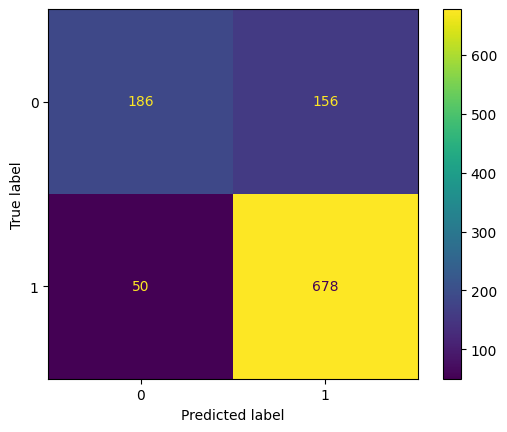

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#pipeline for feature extraction using Tfidf and random forest model
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

#hyperparameters to tune
params = {
    'clf__max_depth': [2, 4, 6],
    'clf__min_samples_split': [2, 4, 10],
    'clf__min_samples_leaf': [4, 6, 8]
}
# Use GridSearchCV to tune hyperparameters and select the best model
grid_search = GridSearchCV(pipeline, params, cv=4)
grid_search.fit(X_train_vect_avg, y_val_train.values.ravel())

#results of the grid search
results = grid_search.cv_results_

# Print the performance for each set of hyperparameters
for i in range(len(results['params'])):
    print("Parameters: ", results['params'][i])
    print("Mean accuracy on validation set: ", results['mean_test_score'][i])

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test_vect_avg)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression

#pipeline for feature extraction using Tfidf and logistic regression model
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,random_state=42))
])

#hyperparameters to tune
params = {
    'clf__C': [ 0.01, 0.1, 1, 5, 8, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
}

# Use GridSearchCV to tune hyperparameters and select the best model
grid_search = GridSearchCV(pipeline, params, cv=4,error_score=0)
grid_search.fit(X_train_vect_avg, y_val_train.values.ravel())

GridSearchCV(cv=4, error_score=0,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 5, 8, 10],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear', 'saga']})

In [ ]:
# Get the results of the grid search
results = grid_search.cv_results_

# Print the performance metrics for each set of hyperparameters on validation set
for i in range(len(results['params'])):
    print("Parameters: ", results['params'][i])
    print("Mean accuracy on validation set: ", results['mean_test_score'][i])

Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.685981308411215
Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Mean accuracy on validation set:  0.685981308411215
Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.685981308411215
Parameters:  {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Mean accuracy on validation set:  0.685981308411215
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.705607476635514
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Mean accuracy on validation set:  0.7067757009345794
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mean accuracy on validation set:  0.7149532710280374
Parameters:  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Mean accuracy on v

Best Parameters: {'clf__C': 8, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Test Accuracy: 0.8019
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       342
           1       0.84      0.88      0.86       728

    accuracy                           0.80      1070
   macro avg       0.78      0.76      0.76      1070
weighted avg       0.80      0.80      0.80      1070



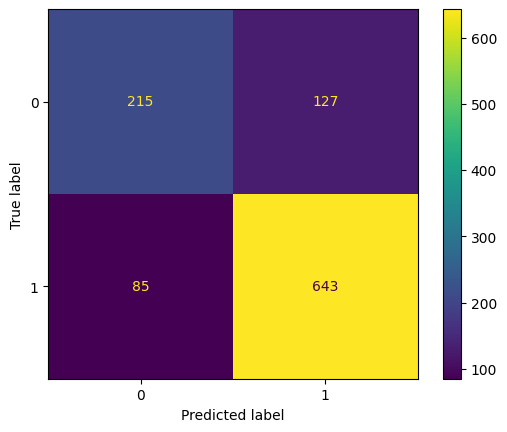

In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test_vect_avg)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

Test Accuracy: 0.7991
              precision    recall  f1-score   support

           0       0.73      0.60      0.65       342
           1       0.83      0.89      0.86       728

    accuracy                           0.80      1070
   macro avg       0.78      0.75      0.76      1070
weighted avg       0.79      0.80      0.79      1070



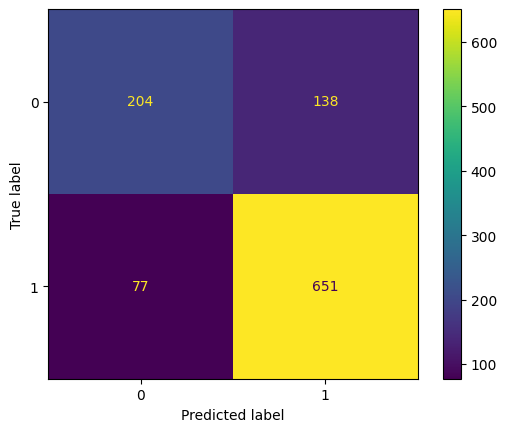

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc_model = svc.fit(X_train_vect_avg, y_val_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = svc_model.predict(X_test_vect_avg)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.8579
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       342
           1       0.92      0.87      0.89       728

    accuracy                           0.86      1070
   macro avg       0.83      0.85      0.84      1070
weighted avg       0.86      0.86      0.86      1070



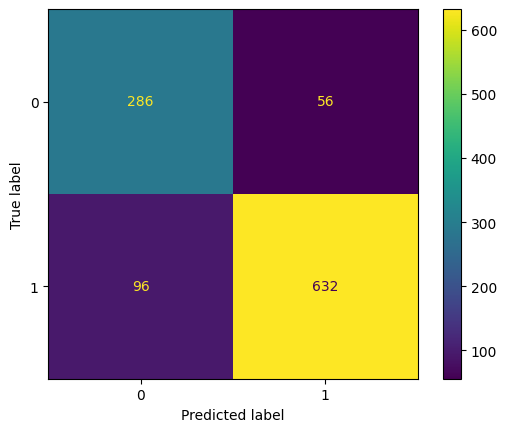

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp_model = mlp.fit(X_train_vect_avg, y_val_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = mlp_model.predict(X_test_vect_avg)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

Test Accuracy: 0.8187
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       342
           1       0.87      0.87      0.87       728

    accuracy                           0.82      1070
   macro avg       0.79      0.79      0.79      1070
weighted avg       0.82      0.82      0.82      1070



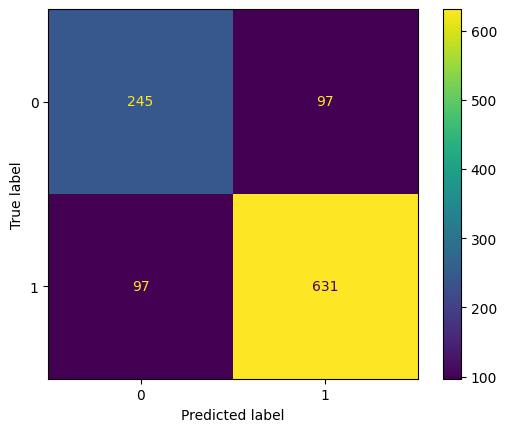

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb_model = gb.fit(X_train_vect_avg, y_val_train.values.ravel())

# Use the trained model to make predictions on the test data
y_pred = gb_model.predict(X_test_vect_avg)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

##Glove

In [ ]:
import gensim.downloader as api

# Load the pre-trained GloVe model
model = api.load("glove-wiki-gigaword-300")

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove

import numpy as np
from tqdm import tqdm

# Load GloVe model
glove_file = 'glove/glove.6B.300d.txt'
glove_model = {}
with open(glove_file, 'r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector

NotImplementedError: ignored

In [ ]:
# Function to convert text to GloVe features
def text_to_vector(text):
    # Join the list of words into a single string
    text_str = ' '.join(text)

    # Split the text into individual words
    words = text_str.split()

    # Initialize an empty vector of zeros
    vector = np.zeros(300)

    # Iterate over each word in the text
    for word in words:
        # If the word is in the GloVe embeddings vocabulary, add its vector to the text vector
        if word in glove_model:
            vector += glove_model[word]

    return vector

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

# Convert the text to GloVe features for the training and test sets
train_vectors = np.stack(X_val_train.apply(text_to_vector))
test_vectors = np.stack(X_test.apply(text_to_vector))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

#pipeline for feature extraction using Tfidf and decision tree model
pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])

#important hyperparameters
params = {
    'clf__max_depth': [1,3,5,7],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,3,7,10]
}

# Usng GridSearchCV to tune hyperparameters and select the best model
grid_search = GridSearchCV(pipeline, params, cv=4)
grid_search.fit(train_vectors, y_val_train)

#results of the grid search
results = grid_search.cv_results_

#performance for each set of hyperparameters
for i in range(len(results['params'])):
    print("Parameters: ", results['params'][i])
    print("Mean accuracy on validation set: ", results['mean_test_score'][i])

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model on the test set
y_pred = best_model.predict(test_vectors)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

In [ ]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(train_vectors, y_val_train)

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(test_vectors)

# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(accuracy, 3)))

Precision: 0.808 / Recall: 0.902 / Accuracy: 0.788


##Doc2Vec

In [ ]:
import gensim
from gensim.models import doc2vec

In [ ]:
# Created TaggedDocument vectors for each text message in the training and test sets
tagged_docs_train = [gensim.models.doc2vec.TaggedDocument(v, [i])
                     for i, v in enumerate(X_val_train)]
tagged_docs_test = [gensim.models.doc2vec.TaggedDocument(v, [i])
                    for i, v in enumerate(X_test)]
# Train a basic doc2vec model
d2v_model = gensim.models.Doc2Vec(tagged_docs_train,
                                  vector_size=100,
                                  window=5,
                                  min_count=2)
# Infer the vectors to be used in training and testing
train_vectors = [d2v_model.infer_vector(v.words) for v in tagged_docs_train]
test_vectors = [d2v_model.infer_vector(v.words) for v in tagged_docs_test]

Test Accuracy: 0.7804
              precision    recall  f1-score   support

           0       0.71      0.52      0.60       342
           1       0.80      0.90      0.85       728

    accuracy                           0.78      1070
   macro avg       0.76      0.71      0.73      1070
weighted avg       0.77      0.78      0.77      1070



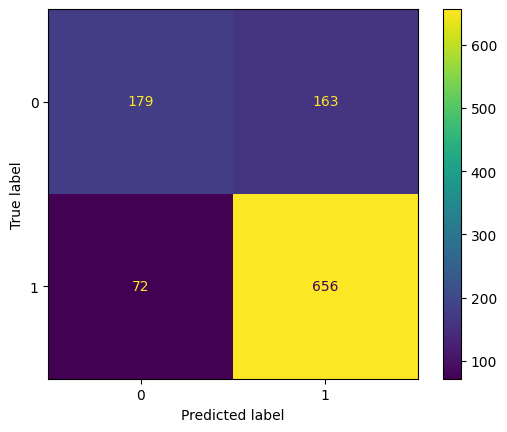

In [ ]:
rf = RandomForestClassifier()
rf_model = rf.fit(train_vectors,y_val_train)

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(test_vectors)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))

Test Accuracy: 0.8131
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       342
           1       0.83      0.91      0.87       728

    accuracy                           0.81      1070
   macro avg       0.80      0.76      0.77      1070
weighted avg       0.81      0.81      0.81      1070

Precision: 0.832 / Recall: 0.909 / Accuracy: 0.813


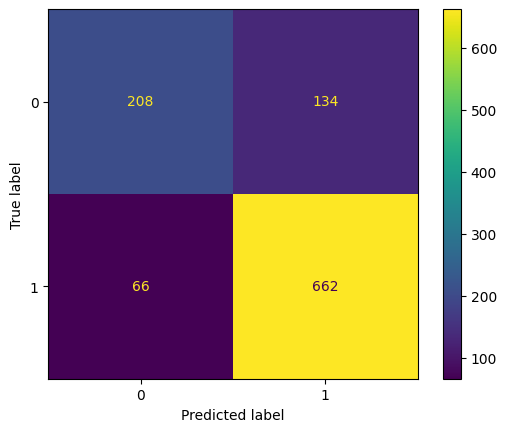

In [ ]:
svc =SVC()
svc_model = svc.fit(train_vectors,y_val_train)

# Use the trained model to make predictions on the test data
y_pred = svc_model.predict(test_vectors)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = (y_pred==y_test).sum()/len(y_pred)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(accuracy, 3)))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.8093
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       342
           1       0.85      0.87      0.86       728

    accuracy                           0.81      1070
   macro avg       0.78      0.77      0.78      1070
weighted avg       0.81      0.81      0.81      1070

Precision: 0.852 / Recall: 0.871 / Accuracy: 0.809


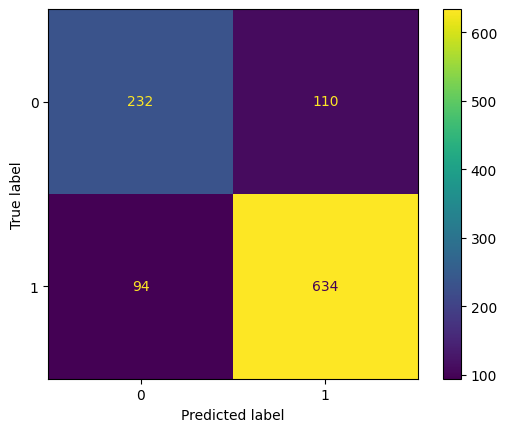

In [ ]:
mlp = MLPClassifier()
mlp_model = mlp.fit(train_vectors,y_val_train)

# Use the trained model to make predictions on the test data
y_pred = mlp_model.predict(test_vectors)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = (y_pred==y_test).sum()/len(y_pred)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(accuracy, 3)))

In [ ]:
print("Training:"+str(mlp.score(train_vectors,y_val_train)))
print("Test:"+str(mlp.score(test_vectors,y_test)))

Training:0.9806074766355141
Test:0.8093457943925234


Test Accuracy: 0.7850
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       342
           1       0.79      0.93      0.85       728

    accuracy                           0.79      1070
   macro avg       0.77      0.70      0.72      1070
weighted avg       0.78      0.79      0.77      1070

Precision: 0.792 / Recall: 0.927 / Accuracy: 0.785


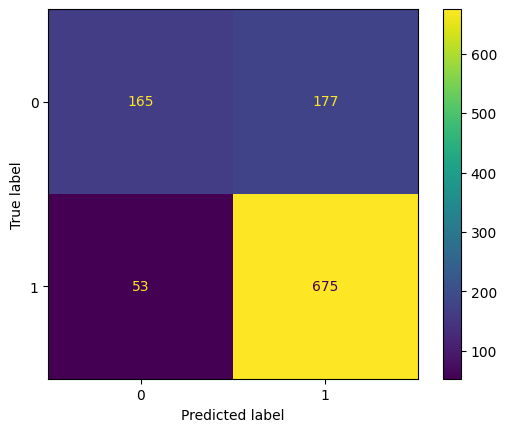

In [ ]:
gb = GradientBoostingClassifier()
gb_model = gb.fit(train_vectors,y_val_train)

# Use the trained model to make predictions on the test data
y_pred = gb_model.predict(test_vectors)

accuracy = accuracy_score(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
CMD.from_predictions(y_test,y_pred)
print(CR(y_test,y_pred))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = (y_pred==y_test).sum()/len(y_pred)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(accuracy, 3)))

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit a Logistic Regression model on top of the vectors
lr = LogisticRegression(max_iter=2500)
lr_model = lr.fit(train_vectors, y_val_train)

# Use the trained model to make predictions on the test data
y_pred = lr_model.predict(test_vectors)

# Evaluate the predictions of the model on the holdout test set
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(accuracy, 3)))

Precision: 0.795 / Recall: 0.913 / Accuracy: 0.78


##Bert

In [ ]:
pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
#Now lets import BERT model and get embeding vectors for few sample statements
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
#Train the model
model.fit(X_val_train, y_val_train, epochs=5)

Epoch 1/5
134/134 [==============================] - 48s 355ms/step - loss: 0.5483 - accuracy: 0.7152 - precision: 0.7303 - recall: 0.9271
Epoch 2/5
134/134 [==============================] - 48s 359ms/step - loss: 0.5258 - accuracy: 0.7322 - precision: 0.7402 - recall: 0.9394
Epoch 3/5
134/134 [==============================] - 49s 362ms/step - loss: 0.5134 - accuracy: 0.7458 - precision: 0.7567 - recall: 0.9278
Epoch 4/5
134/134 [==============================] - 49s 366ms/step - loss: 0.5035 - accuracy: 0.7460 - precision: 0.7583 - recall: 0.9244
Epoch 5/5
134/134 [==============================] - 50s 370ms/step - loss: 0.4875 - accuracy: 0.7619 - precision: 0.7724 - recall: 0.9257


In [ ]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 13s 347ms/step - loss: 0.4911 - accuracy: 0.7393 - precision: 0.7336 - recall: 0.9684


[0.49111732840538025,
 0.7392523288726807,
 0.7336108088493347,
 0.968406617641449]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

34/34 [==============================] - 13s 347ms/step


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[ 86, 256],
       [ 23, 705]])

Text(50.722222222222214, 0.5, 'Truth')

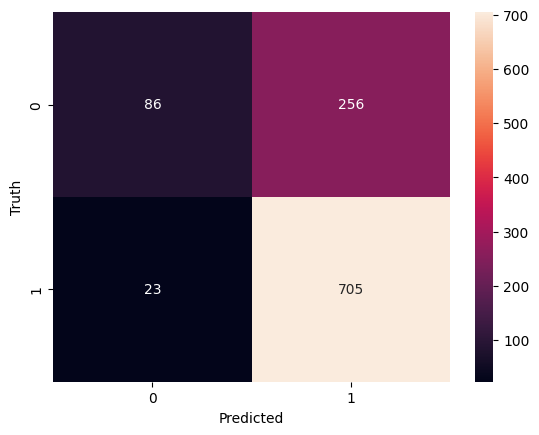

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.25      0.38       342
           1       0.73      0.97      0.83       728

    accuracy                           0.74      1070
   macro avg       0.76      0.61      0.61      1070
weighted avg       0.75      0.74      0.69      1070



#RNN

In [ ]:
df.head(5)

,text,source,fake
0,Modern two-dimensional imaging is of such qual...,sdg_abstracts_original,0
1,Background: The optimal sequence of systemic p...,generated_sdg,1
2,This chapter opens with a discussion of the ef...,summarized_sdg,1
3,The time scale of the ultra-short-term can str...,micpro_retracted,1
4,Electronic nose or machine olfaction are syste...,generated_micpro,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleanedtext_list'], df['fake'], test_size=0.2,random_state=42)

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
#Preparing data


# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)


In [ ]:
# Import the tools needed and use our previously defined functions to calculate precision and recall
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [ ]:
# Construct our basic RNN model framework
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          817056    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 826,465
Trainable params: 826,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [ ]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train,
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
134/134 [==============================] - 9s 37ms/step - loss: 0.5500 - accuracy: 0.7224 - precision_m: 0.7330 - recall_m: 0.9625 - val_loss: 0.3993 - val_accuracy: 0.8196 - val_precision_m: 0.8755 - val_recall_m: 0.8619
Epoch 2/10
134/134 [==============================] - 6s 42ms/step - loss: 0.2577 - accuracy: 0.8963 - precision_m: 0.9203 - recall_m: 0.9296 - val_loss: 0.4231 - val_accuracy: 0.8121 - val_precision_m: 0.8199 - val_recall_m: 0.9312
Epoch 3/10
134/134 [==============================] - 5s 36ms/step - loss: 0.0925 - accuracy: 0.9671 - precision_m: 0.9735 - recall_m: 0.9785 - val_loss: 0.5035 - val_accuracy: 0.8140 - val_precision_m: 0.8296 - val_recall_m: 0.9154
Epoch 4/10
134/134 [==============================] - 5s 37ms/step - loss: 0.0252 - accuracy: 0.9937 - precision_m: 0.9955 - recall_m: 0.9950 - val_loss: 0.6419 - val_accuracy: 0.8084 - val_precision_m: 0.8532 - val_recall_m: 0.8669
Epoch 5/10
134/134 [==============================] - 5s 35ms/step -

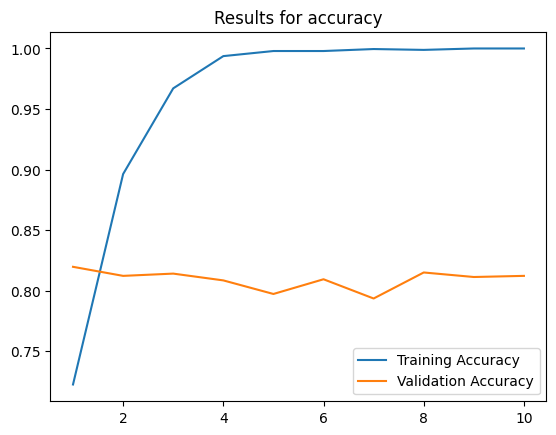

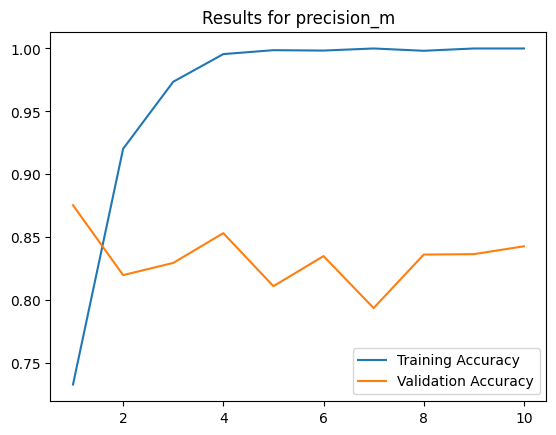

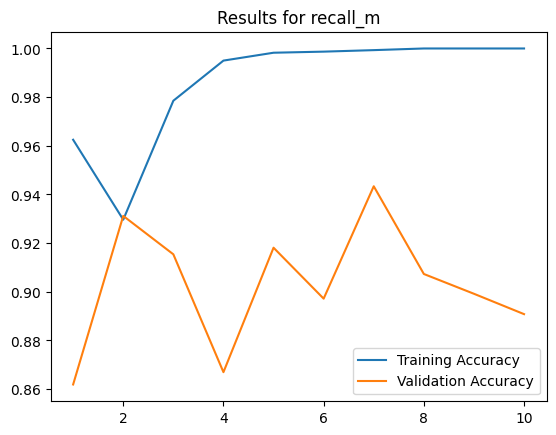

In [ ]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()